# 02 - Exploratory Data Analysis

This notebook provides comprehensive exploratory analysis of the earthquake dataset including:
1. Descriptive Statistics
2. Magnitude Distribution
3. Depth Distribution
4. Spatial Distribution
5. Temporal Patterns
6. Correlation Analysis

## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))

from config import *
from visualization import setup_style, create_turkey_basemap

setup_style()

# Create output directory
OUTPUT_DIR = os.path.join(FIGURES_PATH, '02_eda')
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(TABLES_PATH, exist_ok=True)

print(f"Output directory: {OUTPUT_DIR}")

Output directory: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/figures/02_eda


In [2]:
# Load processed data
processed_file = os.path.join(DATA_PROCESSED, 'earthquakes_processed.csv')

if not os.path.exists(processed_file):
    raise FileNotFoundError(
        f"Processed data not found at {processed_file}\n"
        "Please run notebook 01_data_loading_preprocessing.ipynb first!"
    )

eq_df = pd.read_csv(processed_file)
eq_df['date'] = pd.to_datetime(eq_df['date'], format='mixed')

print(f"Loaded {len(eq_df):,} records")
print(f"Earthquakes (M >= 4.0): {(eq_df['category'] == 'Earthquake').sum():,}")
print(f"Tremors (M < 4.0): {(eq_df['category'] == 'Tremor').sum():,}")

Loaded 524,952 records
Earthquakes (M >= 4.0): 4,103
Tremors (M < 4.0): 520,849


## 2. Descriptive Statistics

In [3]:
# Overall statistics
print("=" * 60)
print("OVERALL STATISTICS")
print("=" * 60)
print(eq_df[['magnitude', 'depth', 'latitude', 'longitude']].describe().round(2))

OVERALL STATISTICS
       magnitude      depth   latitude  longitude
count  524952.00  524952.00  524952.00  524952.00
mean        1.98       8.17      38.52      32.92
std         0.71       5.41       1.25       5.52
min         0.20       0.00      35.50      25.50
25%         1.40       6.99      37.63      27.98
50%         1.90       7.00      38.46      30.81
75%         2.50       7.13      39.27      37.81
max         7.70     191.30      42.50      45.00


In [4]:
# Statistics by category
print("\n" + "=" * 60)
print("STATISTICS BY CATEGORY")
print("=" * 60)

for cat in ['Earthquake', 'Tremor']:
    subset = eq_df[eq_df['category'] == cat]
    print(f"\n{cat} (n = {len(subset):,}):")
    print(f"  Magnitude: {subset['magnitude'].mean():.2f} ± {subset['magnitude'].std():.2f} (range: {subset['magnitude'].min():.1f} - {subset['magnitude'].max():.1f})")
    print(f"  Depth: {subset['depth'].mean():.1f} ± {subset['depth'].std():.1f} km")


STATISTICS BY CATEGORY

Earthquake (n = 4,103):
  Magnitude: 4.34 ± 0.40 (range: 4.0 - 7.7)
  Depth: 12.9 ± 11.3 km

Tremor (n = 520,849):
  Magnitude: 1.96 ± 0.68 (range: 0.2 - 3.9)
  Depth: 8.1 ± 5.3 km


In [5]:
# Top provinces by earthquake count
print("\nTop 15 Provinces by Event Count:")
province_counts = eq_df.groupby('province').agg({
    'eventID': 'count',
    'magnitude': ['mean', 'max']
}).round(2)
province_counts.columns = ['count', 'mag_mean', 'mag_max']
province_counts = province_counts.sort_values('count', ascending=False)
print(province_counts.head(15))


Top 15 Provinces by Event Count:
               count  mag_mean  mag_max
province                               
Muğla          62335      2.00      6.5
İzmir          37572      2.05      6.6
Malatya        37361      1.74      5.9
Kahramanmaraş  32720      1.94      7.7
Balıkesir      31996      1.77      6.1
Manisa         24986      1.88      5.5
Kütahya        24732      2.03      5.4
Van            21480      2.40      6.7
Çanakkale      19196      1.99      5.6
Denizli        17361      1.96      6.0
Elazığ         13125      1.94      6.8
Adıyaman       11766      1.76      5.5
Ankara         11680      2.05      5.6
Adana          11136      1.95      5.9
Aydın          10569      2.04      5.1


## 3. Magnitude Distribution

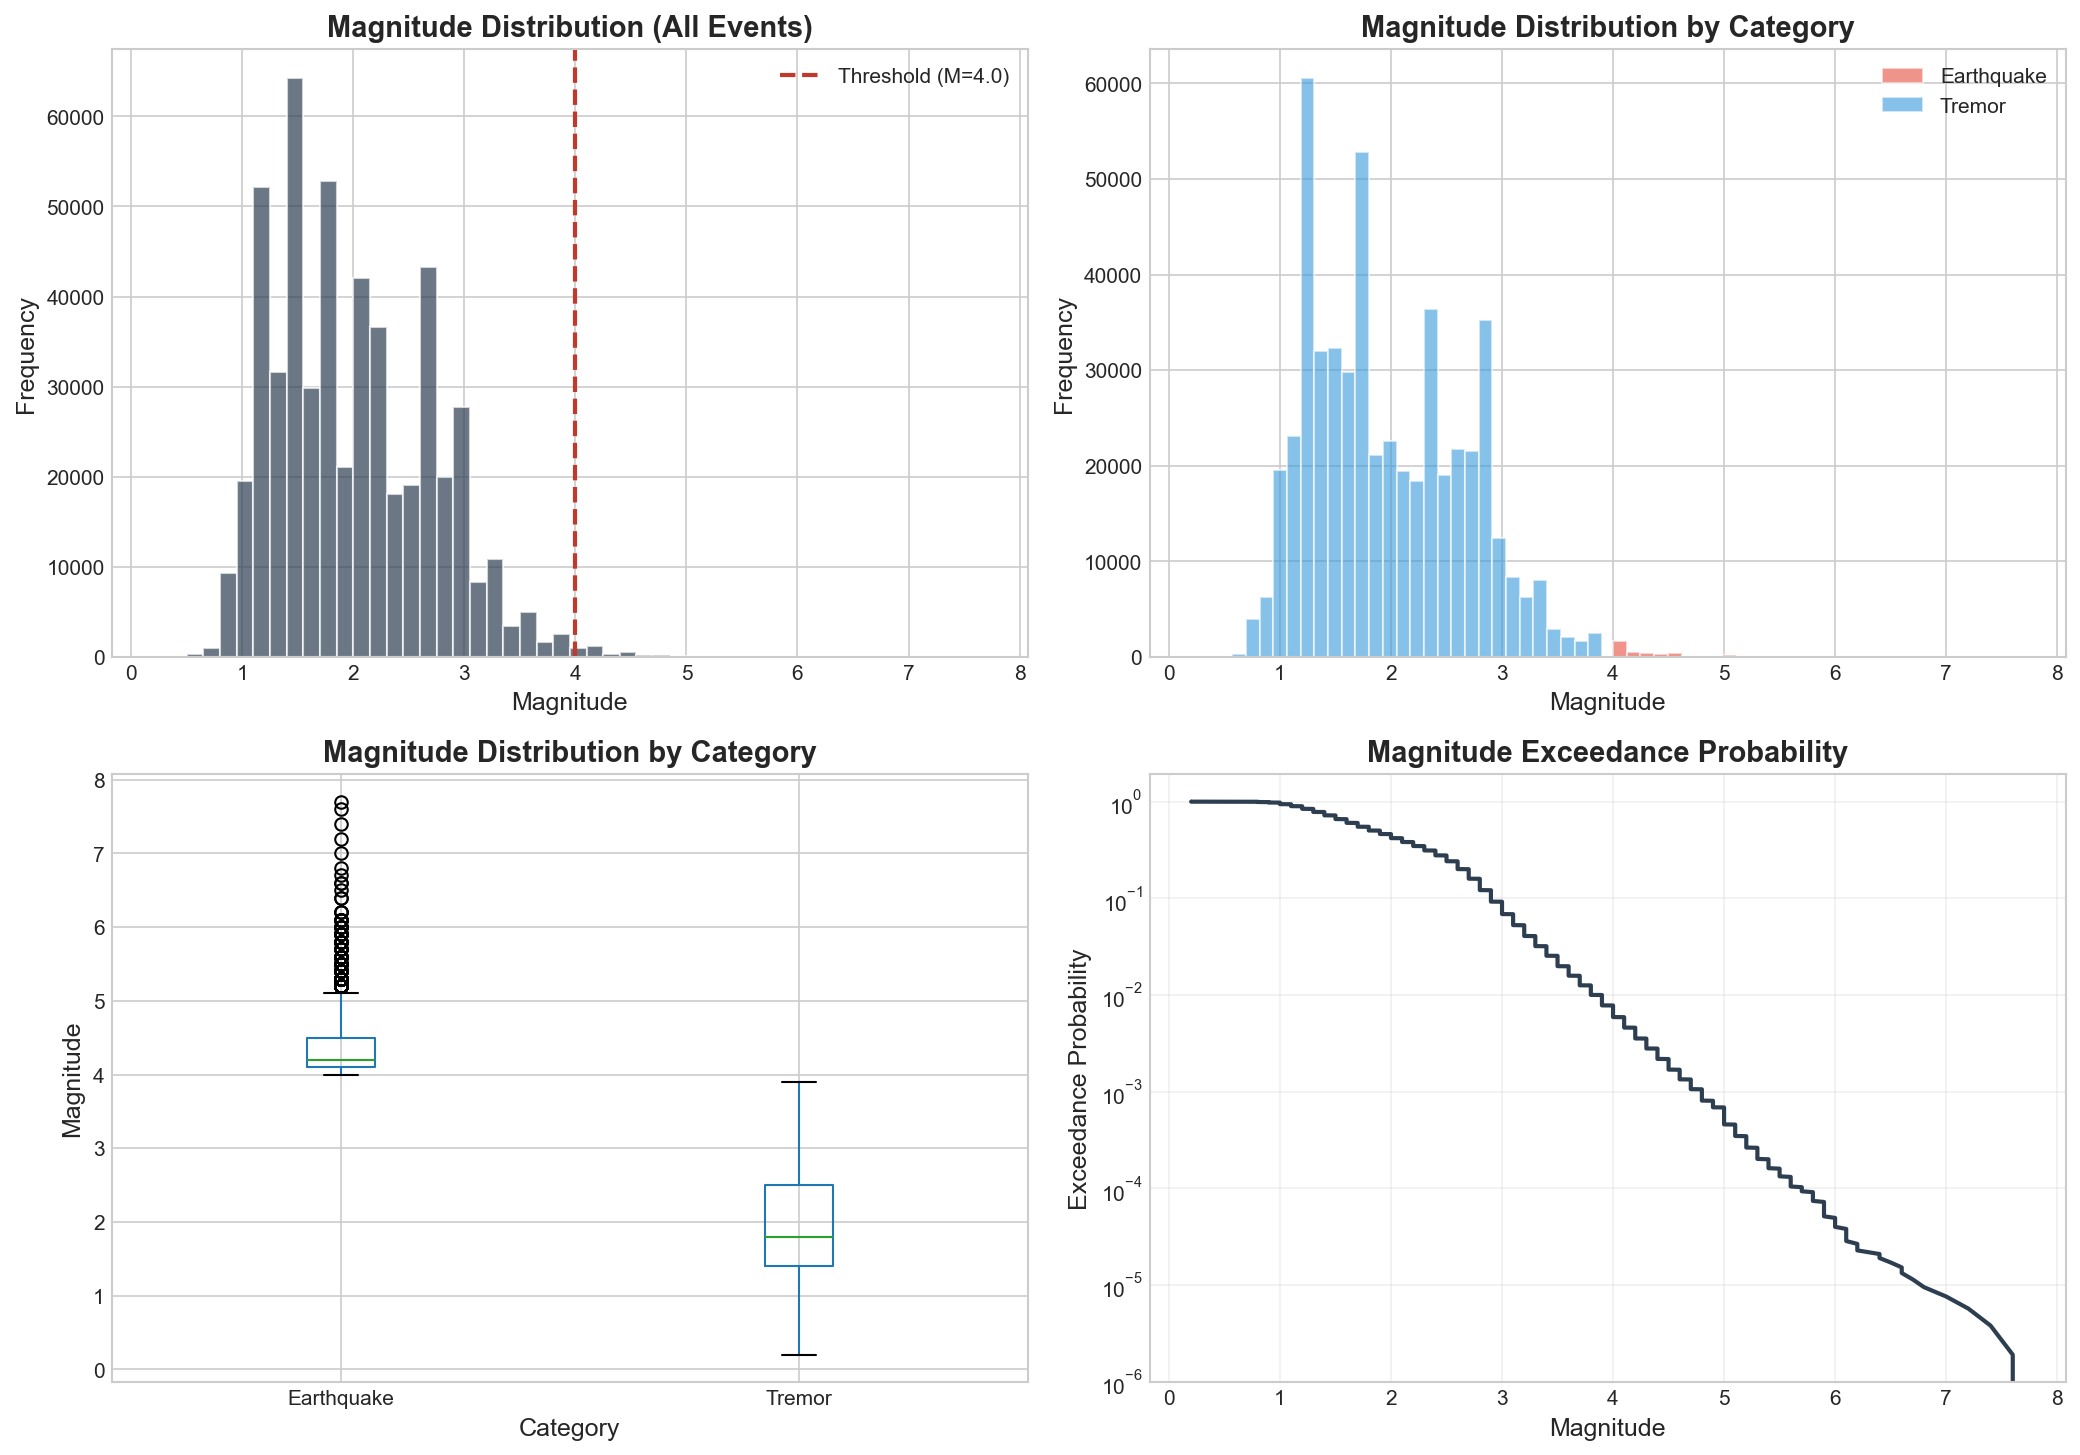

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram - All events
ax1 = axes[0, 0]
ax1.hist(eq_df['magnitude'], bins=50, color=COLORS['primary'], alpha=0.7, edgecolor='white')
ax1.axvline(MAGNITUDE_THRESHOLD, color=COLORS['danger'], linestyle='--', linewidth=2, 
            label=f'Threshold (M={MAGNITUDE_THRESHOLD})')
ax1.set_xlabel('Magnitude')
ax1.set_ylabel('Frequency')
ax1.set_title('Magnitude Distribution (All Events)', fontweight='bold')
ax1.legend()

# Histogram - By category
ax2 = axes[0, 1]
for cat, color in [('Earthquake', COLORS['earthquake']), ('Tremor', COLORS['tremor'])]:
    subset = eq_df[eq_df['category'] == cat]
    ax2.hist(subset['magnitude'], bins=30, alpha=0.6, label=cat, color=color, edgecolor='white')
ax2.set_xlabel('Magnitude')
ax2.set_ylabel('Frequency')
ax2.set_title('Magnitude Distribution by Category', fontweight='bold')
ax2.legend()

# Box plot by category
ax3 = axes[1, 0]
eq_df.boxplot(column='magnitude', by='category', ax=ax3)
ax3.set_xlabel('Category')
ax3.set_ylabel('Magnitude')
ax3.set_title('Magnitude Distribution by Category', fontweight='bold')
plt.suptitle('')  # Remove automatic title

# Cumulative distribution
ax4 = axes[1, 1]
sorted_mags = np.sort(eq_df['magnitude'])
cum_prob = np.arange(1, len(sorted_mags) + 1) / len(sorted_mags)
ax4.plot(sorted_mags, 1 - cum_prob, color=COLORS['primary'], linewidth=2)
ax4.set_yscale('log')
ax4.set_xlabel('Magnitude')
ax4.set_ylabel('Exceedance Probability')
ax4.set_title('Magnitude Exceedance Probability', fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'magnitude_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

## 4. Depth Distribution

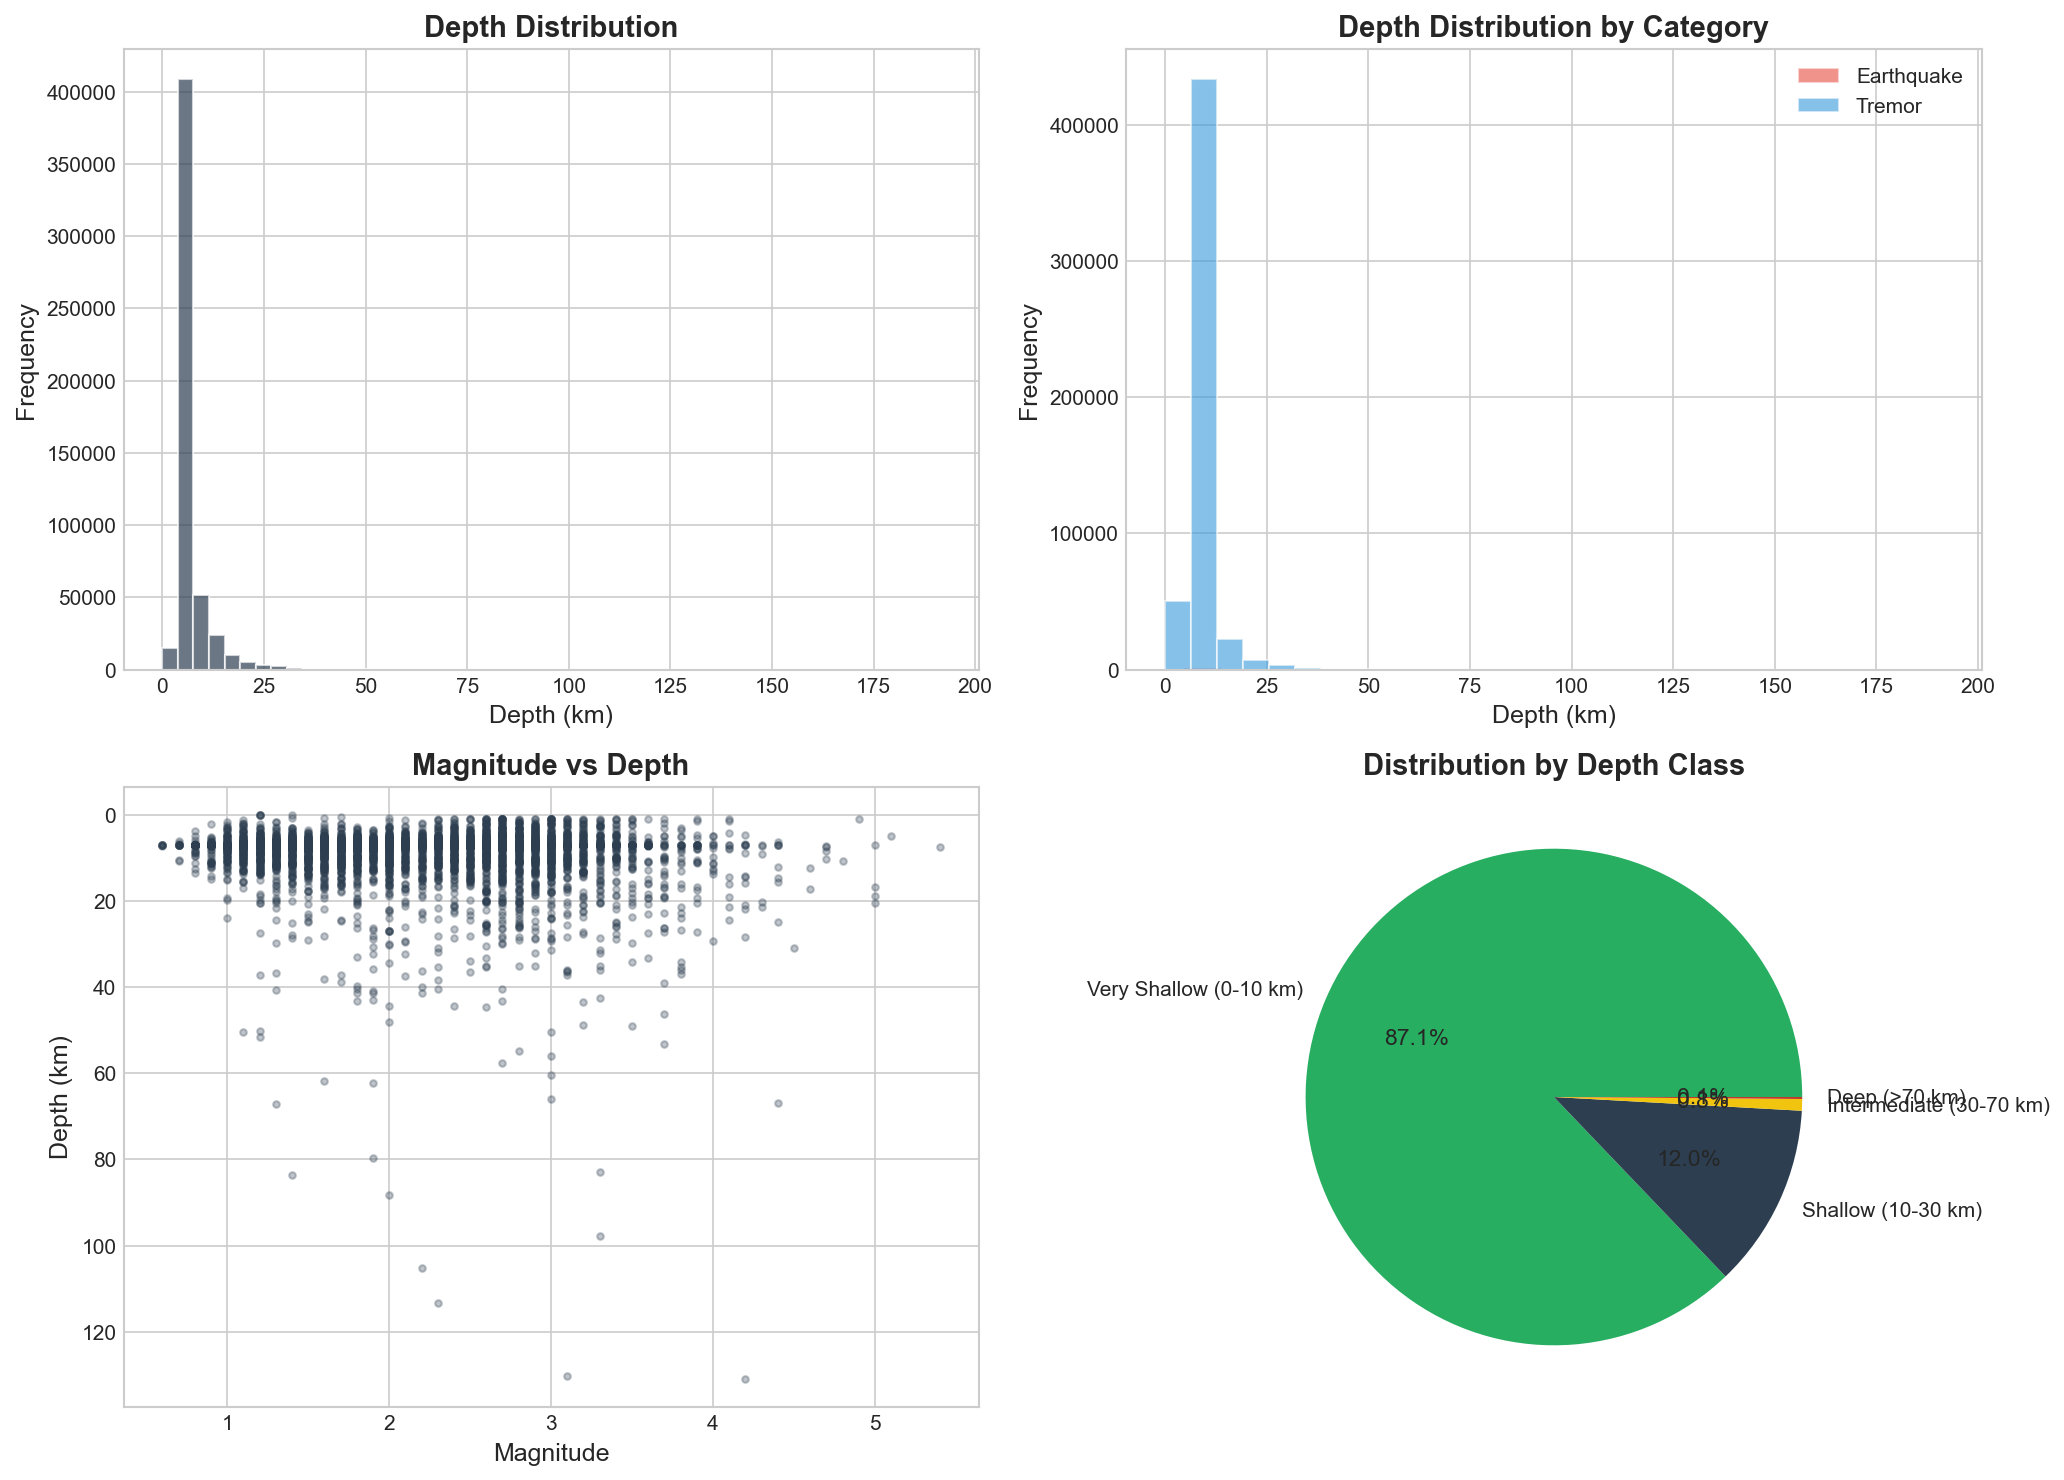

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram
ax1 = axes[0, 0]
ax1.hist(eq_df['depth'], bins=50, color=COLORS['primary'], alpha=0.7, edgecolor='white')
ax1.set_xlabel('Depth (km)')
ax1.set_ylabel('Frequency')
ax1.set_title('Depth Distribution', fontweight='bold')

# Depth by category
ax2 = axes[0, 1]
for cat, color in [('Earthquake', COLORS['earthquake']), ('Tremor', COLORS['tremor'])]:
    subset = eq_df[eq_df['category'] == cat]
    ax2.hist(subset['depth'], bins=30, alpha=0.6, label=cat, color=color, edgecolor='white')
ax2.set_xlabel('Depth (km)')
ax2.set_ylabel('Frequency')
ax2.set_title('Depth Distribution by Category', fontweight='bold')
ax2.legend()

# Depth vs Magnitude scatter
ax3 = axes[1, 0]
sample = eq_df.sample(min(10000, len(eq_df)), random_state=42)
ax3.scatter(sample['magnitude'], sample['depth'], alpha=0.3, s=10, c=COLORS['primary'])
ax3.set_xlabel('Magnitude')
ax3.set_ylabel('Depth (km)')
ax3.set_title('Magnitude vs Depth', fontweight='bold')
ax3.invert_yaxis()

# Depth class distribution
ax4 = axes[1, 1]
depth_counts = eq_df['depth_class'].value_counts()
colors = [COLORS['success'], COLORS['primary'], COLORS['warning'], COLORS['danger']]
ax4.pie(depth_counts, labels=depth_counts.index, autopct='%1.1f%%', colors=colors[:len(depth_counts)])
ax4.set_title('Distribution by Depth Class', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'depth_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

## 5. Spatial Distribution

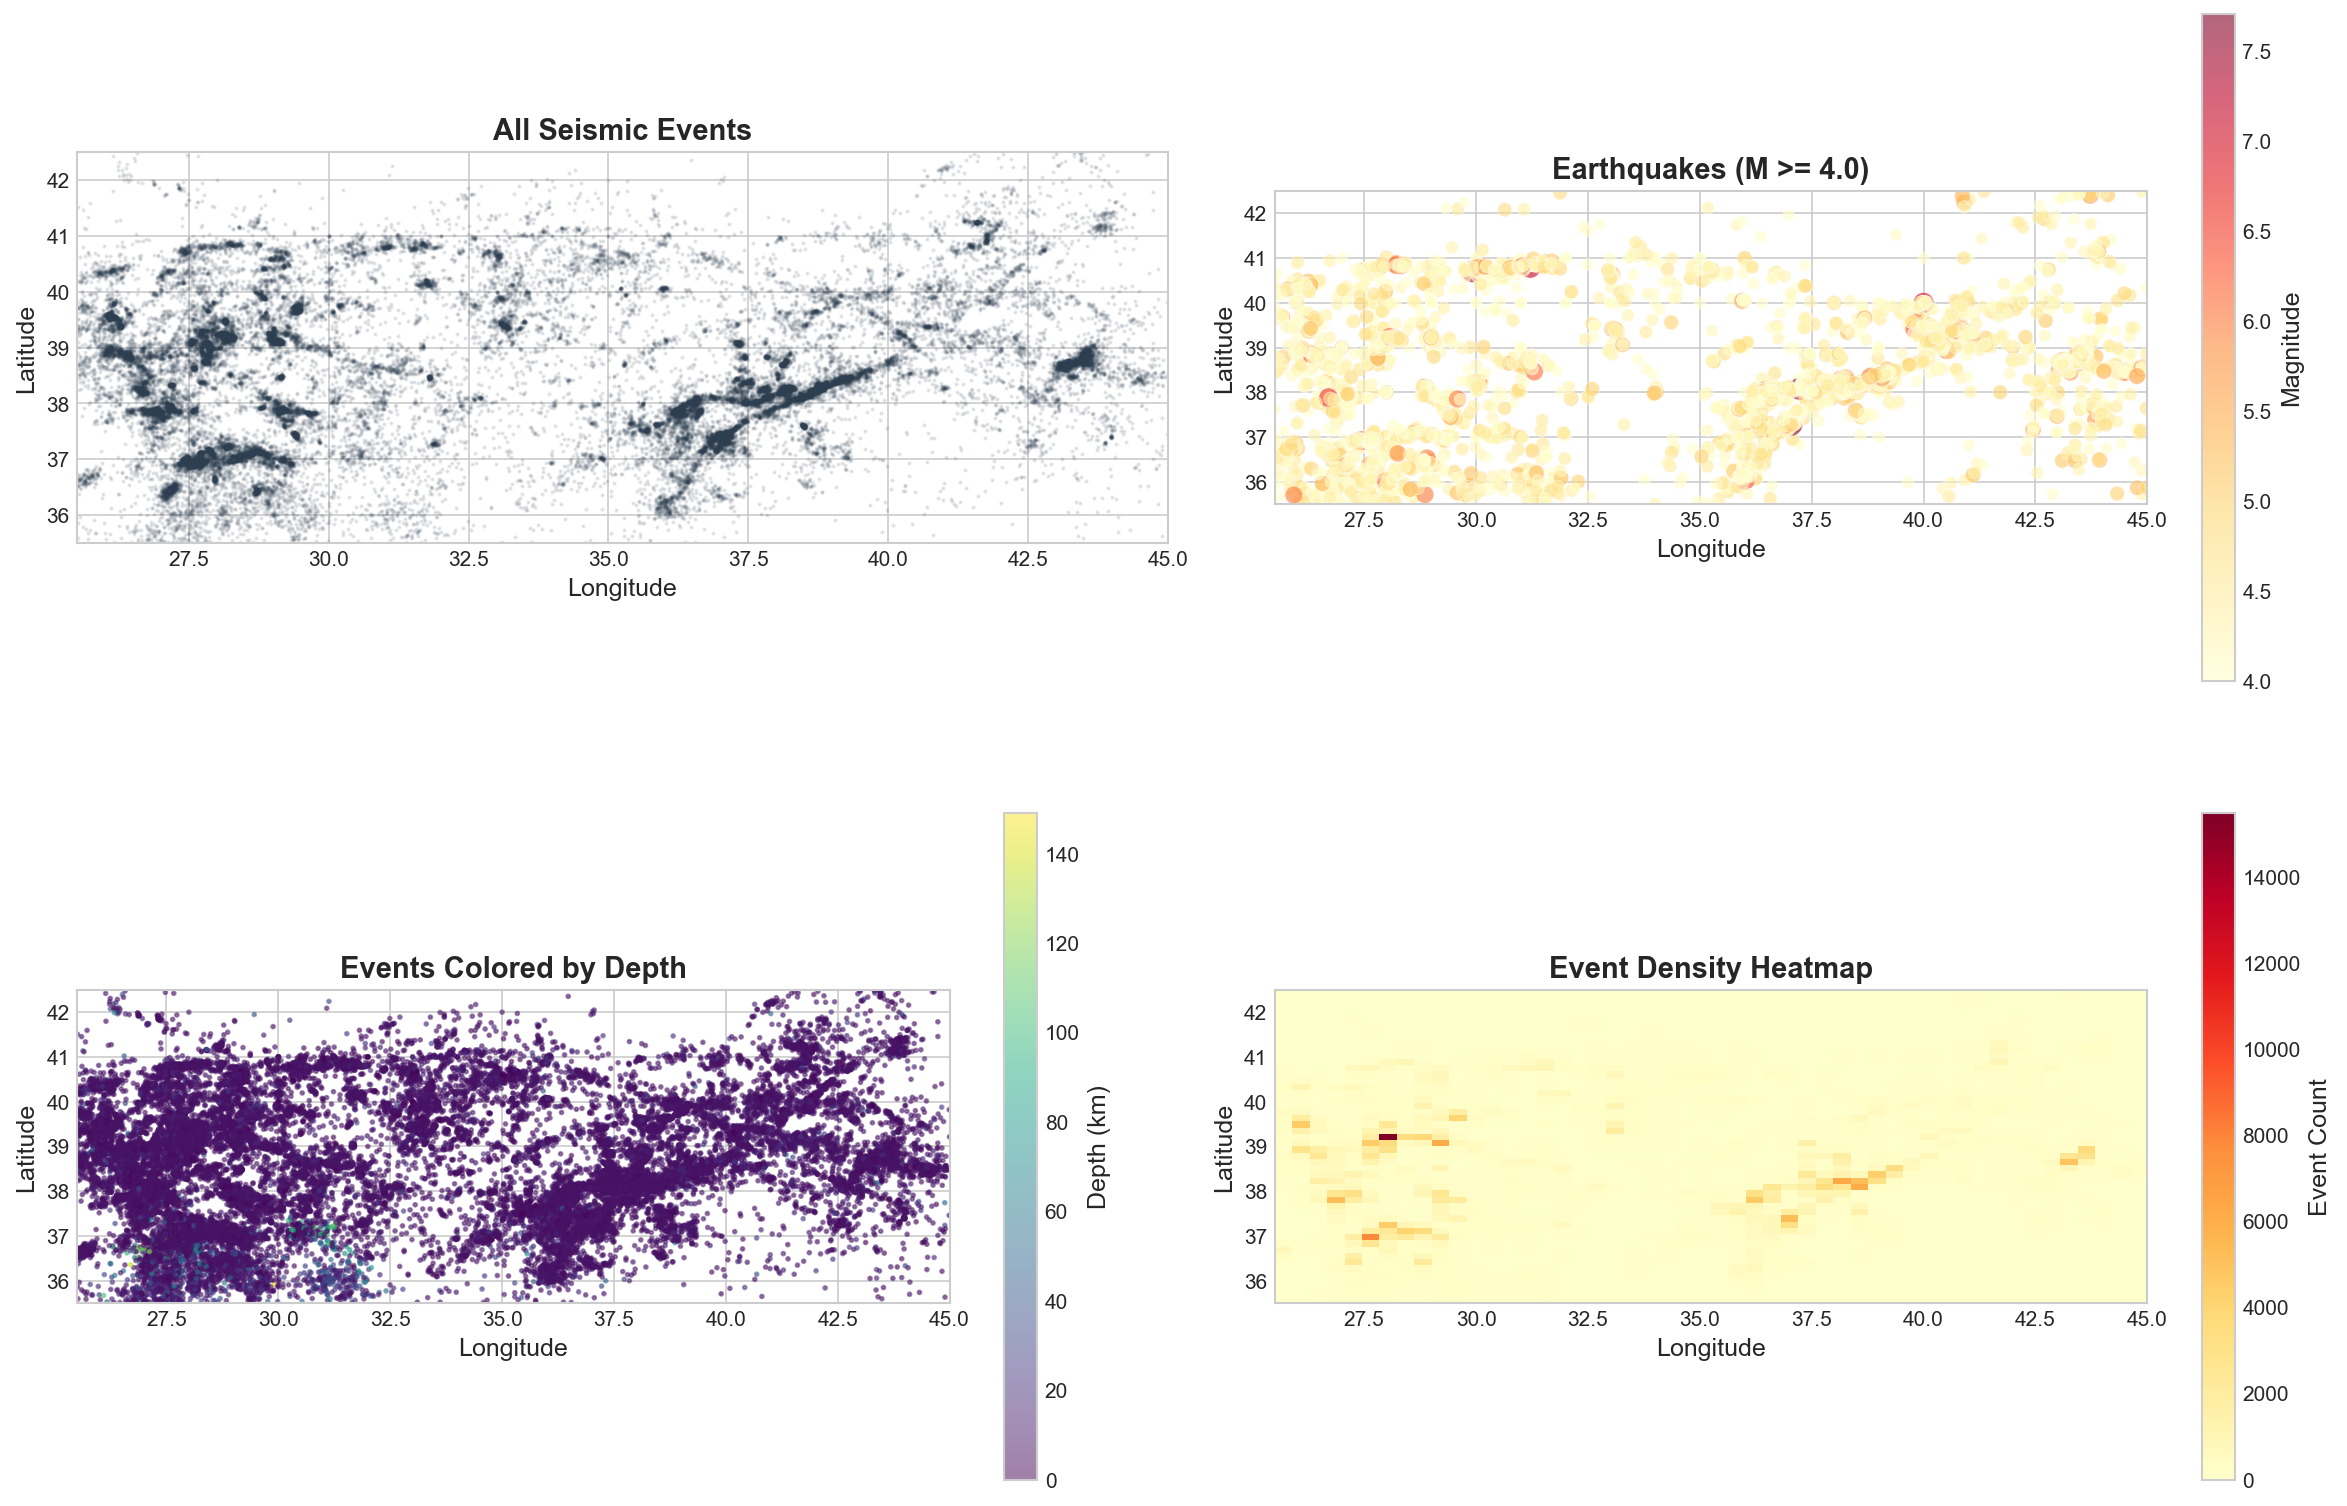

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# All events
ax1 = create_turkey_basemap(axes[0, 0], 'All Seismic Events')
sample = eq_df.sample(min(50000, len(eq_df)), random_state=42)
ax1.scatter(sample['longitude'], sample['latitude'], s=1, alpha=0.1, c=COLORS['primary'])

# Earthquakes only (M >= 4.0)
ax2 = create_turkey_basemap(axes[0, 1], 'Earthquakes (M >= 4.0)')
earthquakes = eq_df[eq_df['category'] == 'Earthquake']
scatter = ax2.scatter(earthquakes['longitude'], earthquakes['latitude'], 
                      c=earthquakes['magnitude'], s=earthquakes['magnitude']**2 * 2,
                      cmap='YlOrRd', alpha=0.6, edgecolors='white', linewidth=0.3)
plt.colorbar(scatter, ax=ax2, label='Magnitude', shrink=0.7)

# Colored by depth
ax3 = create_turkey_basemap(axes[1, 0], 'Events Colored by Depth')
scatter2 = ax3.scatter(sample['longitude'], sample['latitude'], 
                       c=sample['depth'], s=3, cmap=DEPTH_CMAP, alpha=0.5)
plt.colorbar(scatter2, ax=ax3, label='Depth (km)', shrink=0.7)

# 2D histogram / heatmap
ax4 = create_turkey_basemap(axes[1, 1], 'Event Density Heatmap')
h = ax4.hist2d(eq_df['longitude'], eq_df['latitude'], bins=50, cmap=DENSITY_CMAP, 
               range=[[TURKEY_BOUNDS['lon_min'], TURKEY_BOUNDS['lon_max']], 
                      [TURKEY_BOUNDS['lat_min'], TURKEY_BOUNDS['lat_max']]])
plt.colorbar(h[3], ax=ax4, label='Event Count', shrink=0.7)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'spatial_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

## 6. Temporal Patterns

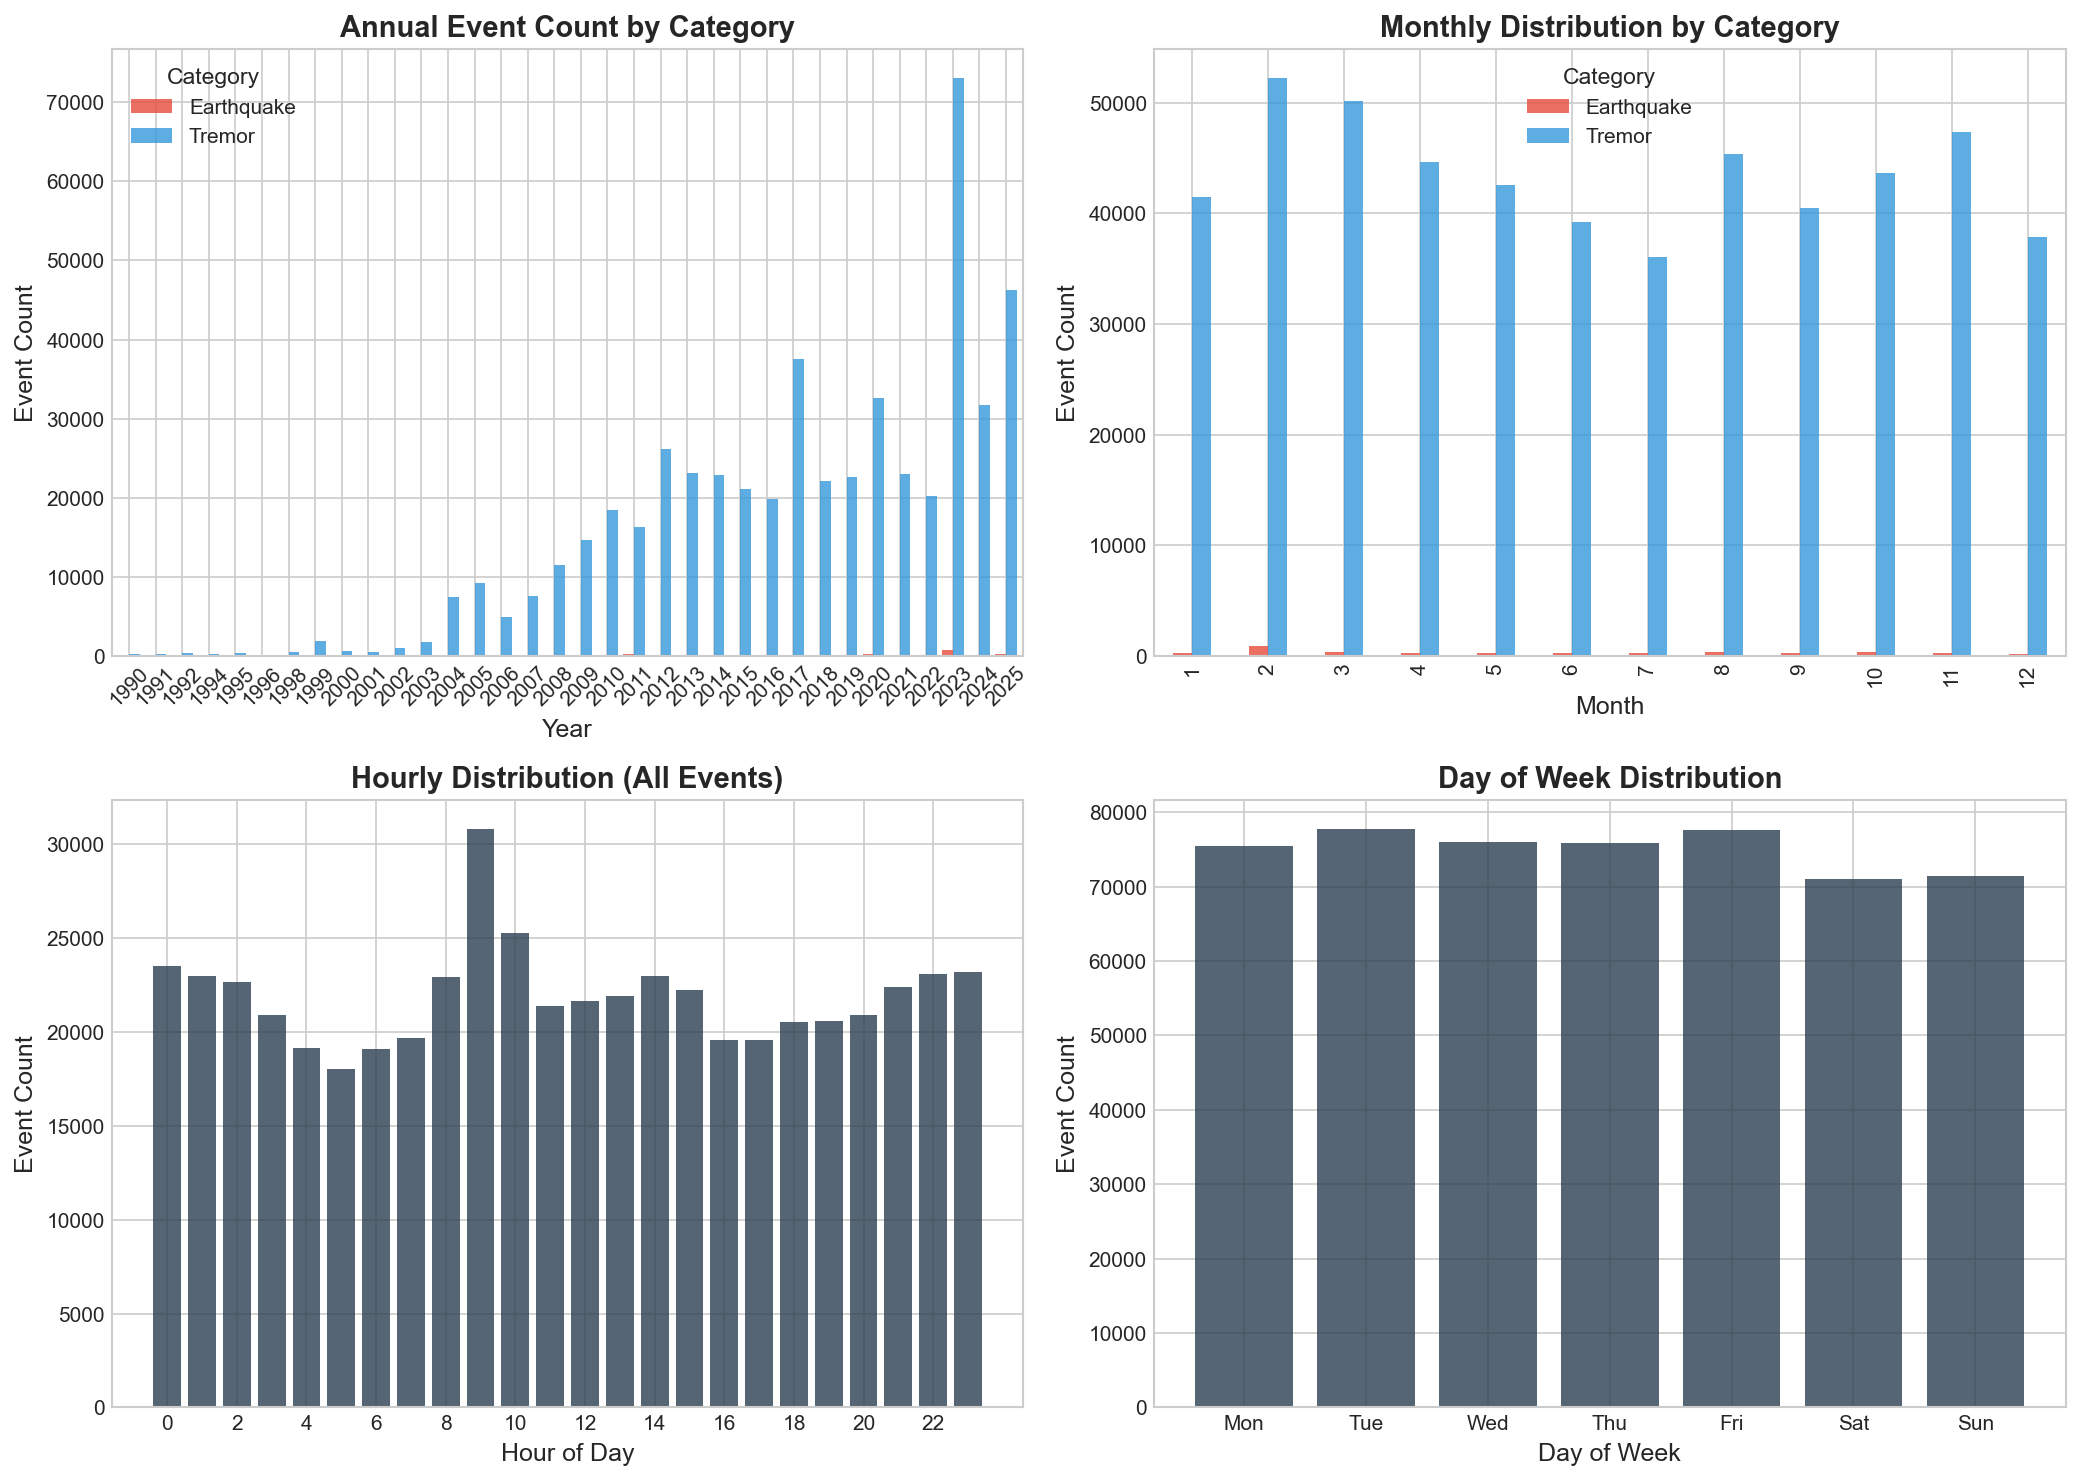

In [9]:
# Yearly trend
yearly = eq_df.groupby(['year', 'category']).size().unstack(fill_value=0)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Yearly counts
ax1 = axes[0, 0]
yearly.plot(kind='bar', ax=ax1, color=[COLORS['earthquake'], COLORS['tremor']], alpha=0.8, width=0.8)
ax1.set_xlabel('Year')
ax1.set_ylabel('Event Count')
ax1.set_title('Annual Event Count by Category', fontweight='bold')
ax1.legend(title='Category')
ax1.tick_params(axis='x', rotation=45)

# Monthly pattern
ax2 = axes[0, 1]
monthly = eq_df.groupby(['month', 'category']).size().unstack(fill_value=0)
monthly.plot(kind='bar', ax=ax2, color=[COLORS['earthquake'], COLORS['tremor']], alpha=0.8)
ax2.set_xlabel('Month')
ax2.set_ylabel('Event Count')
ax2.set_title('Monthly Distribution by Category', fontweight='bold')
ax2.legend(title='Category')

# Hourly pattern
ax3 = axes[1, 0]
hourly = eq_df.groupby('hour').size()
ax3.bar(hourly.index, hourly.values, color=COLORS['primary'], alpha=0.8)
ax3.set_xlabel('Hour of Day')
ax3.set_ylabel('Event Count')
ax3.set_title('Hourly Distribution (All Events)', fontweight='bold')
ax3.set_xticks(range(0, 24, 2))

# Day of week pattern
ax4 = axes[1, 1]
dow = eq_df.groupby('day_of_week').size()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ax4.bar(range(7), dow.values, color=COLORS['primary'], alpha=0.8)
ax4.set_xlabel('Day of Week')
ax4.set_ylabel('Event Count')
ax4.set_title('Day of Week Distribution', fontweight='bold')
ax4.set_xticks(range(7))
ax4.set_xticklabels(days)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'temporal_patterns.png'), dpi=150, bbox_inches='tight')
plt.show()

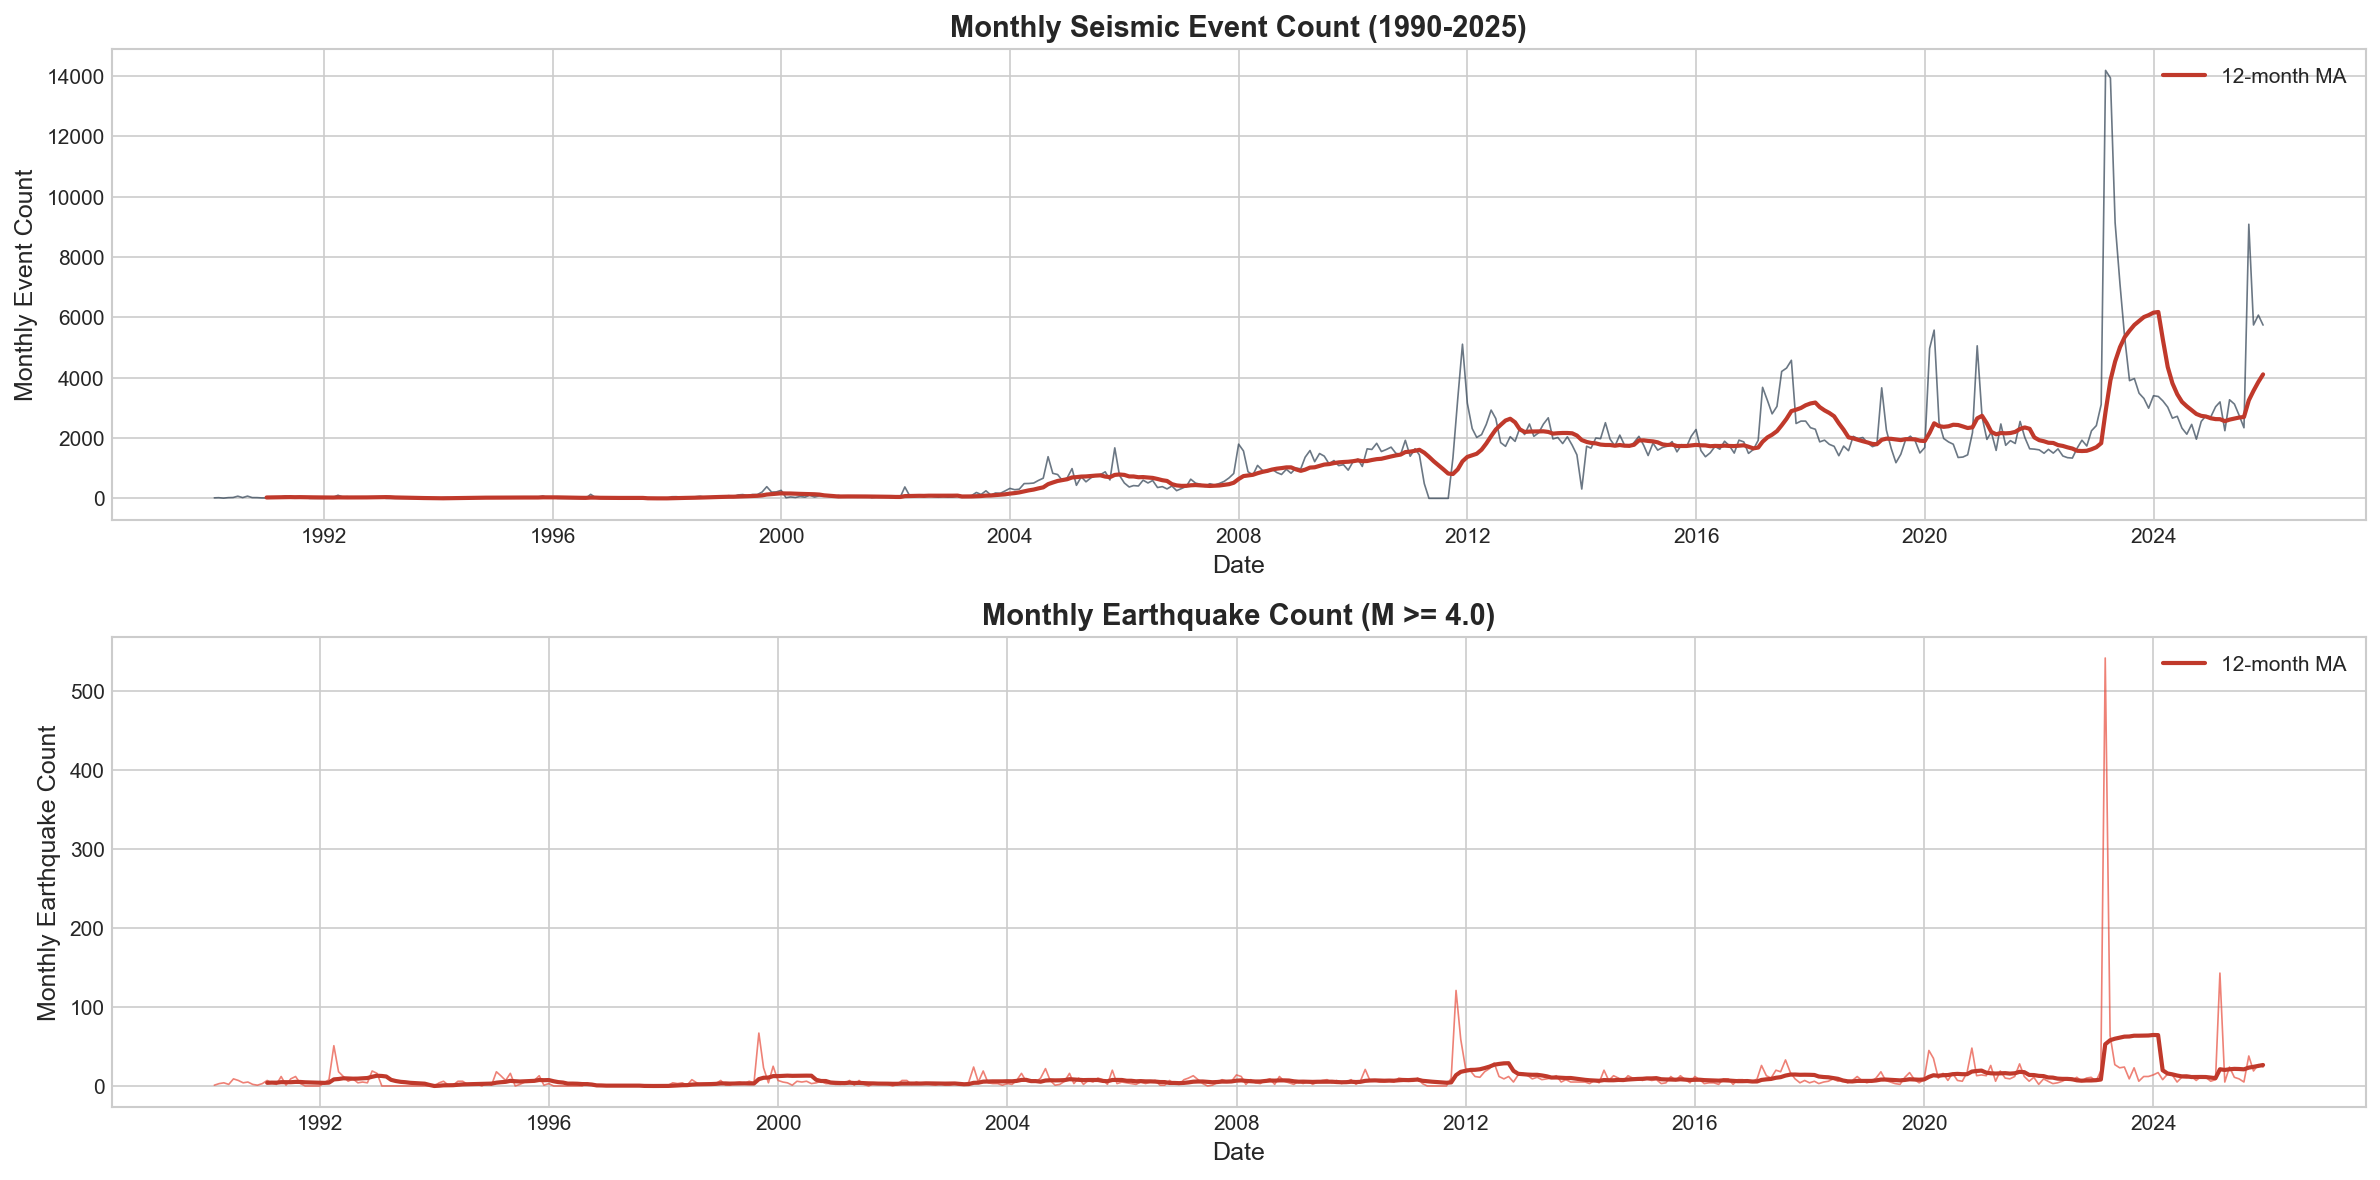

In [10]:
# Time series of earthquake counts
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Monthly time series
monthly_ts = eq_df.set_index('date').resample('M').size()

ax1 = axes[0]
ax1.plot(monthly_ts.index, monthly_ts.values, color=COLORS['primary'], linewidth=0.8, alpha=0.7)
# Add rolling average
rolling = monthly_ts.rolling(window=12).mean()
ax1.plot(rolling.index, rolling.values, color=COLORS['danger'], linewidth=2, label='12-month MA')
ax1.set_xlabel('Date')
ax1.set_ylabel('Monthly Event Count')
ax1.set_title('Monthly Seismic Event Count (1990-2025)', fontweight='bold')
ax1.legend()

# Earthquakes only (M >= 4.0)
eq_only = eq_df[eq_df['category'] == 'Earthquake'].set_index('date').resample('M').size()

ax2 = axes[1]
ax2.plot(eq_only.index, eq_only.values, color=COLORS['earthquake'], linewidth=0.8, alpha=0.7)
rolling_eq = eq_only.rolling(window=12).mean()
ax2.plot(rolling_eq.index, rolling_eq.values, color=COLORS['danger'], linewidth=2, label='12-month MA')
ax2.set_xlabel('Date')
ax2.set_ylabel('Monthly Earthquake Count')
ax2.set_title('Monthly Earthquake Count (M >= 4.0)', fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'time_series.png'), dpi=150, bbox_inches='tight')
plt.show()

## 7. Correlation Analysis

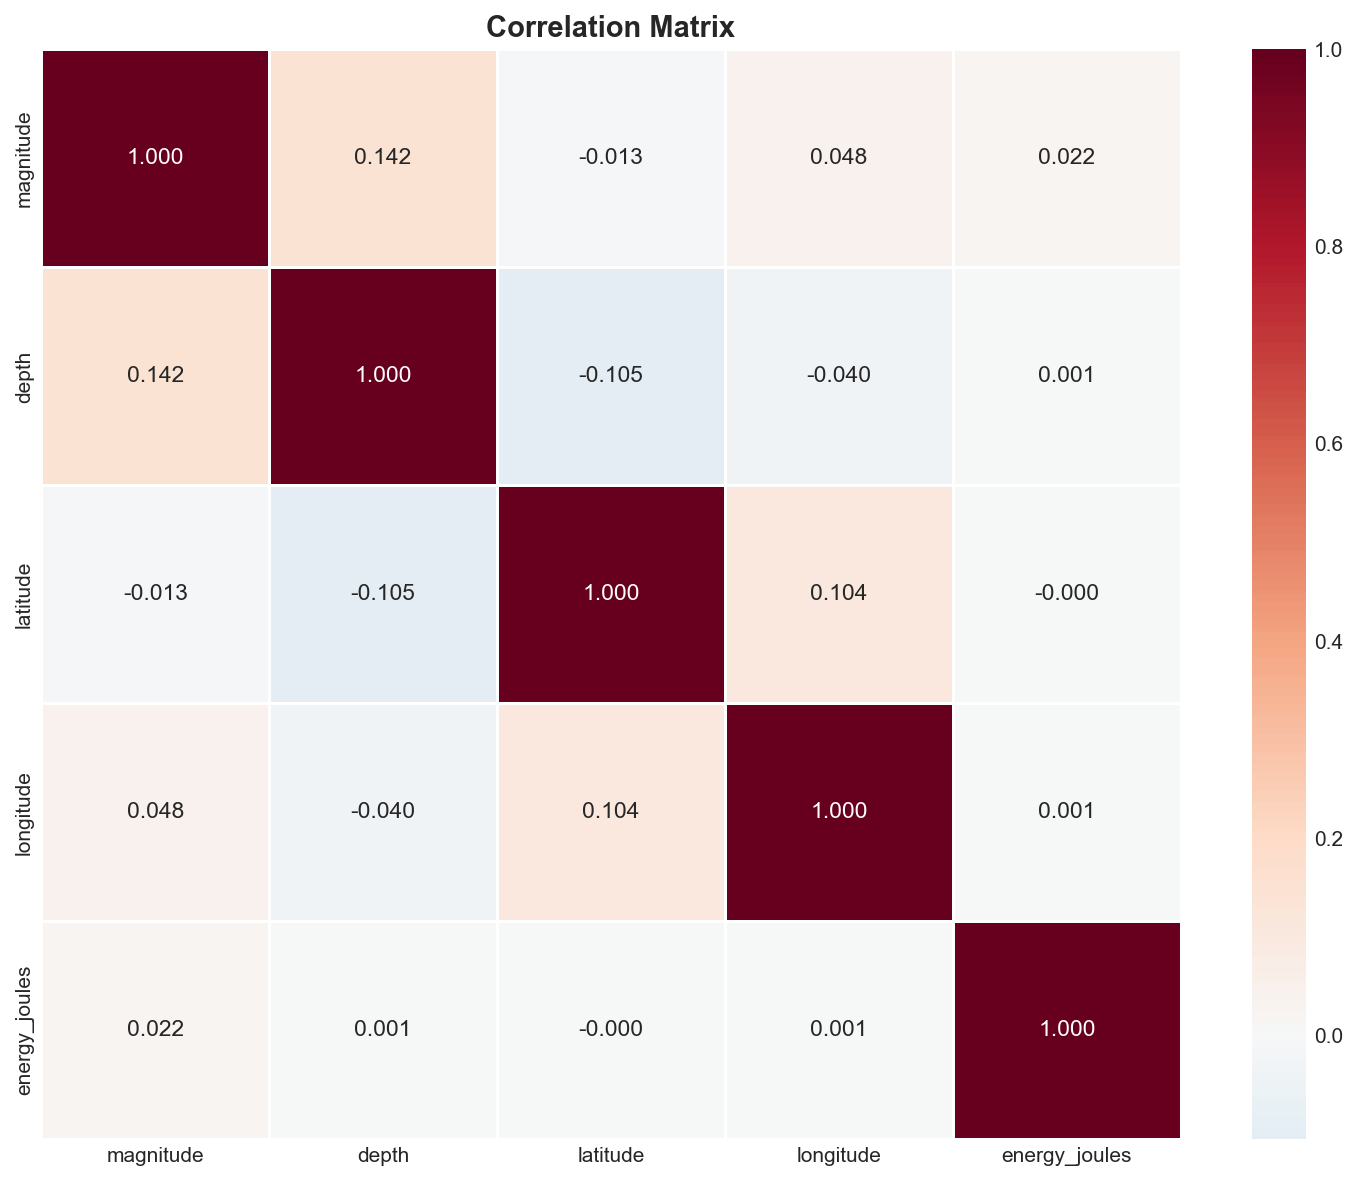


Correlation Statistics:
               magnitude     depth  latitude  longitude  energy_joules
magnitude       1.000000  0.141682 -0.012981   0.048052       0.021806
depth           0.141682  1.000000 -0.105160  -0.040397       0.001070
latitude       -0.012981 -0.105160  1.000000   0.103914      -0.000267
longitude       0.048052 -0.040397  0.103914   1.000000       0.001413
energy_joules   0.021806  0.001070 -0.000267   0.001413       1.000000


In [11]:
# Correlation matrix for numeric variables
numeric_cols = ['magnitude', 'depth', 'latitude', 'longitude', 'energy_joules']
corr_matrix = eq_df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            fmt='.3f', linewidths=0.5, ax=ax)
ax.set_title('Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'correlation_matrix.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\nCorrelation Statistics:")
print(corr_matrix)

In [12]:
# Statistical tests
print("=" * 60)
print("STATISTICAL TESTS")
print("=" * 60)

# Test: Is earthquake frequency uniform across months?
monthly_counts = eq_df['month'].value_counts().sort_index()
expected = np.full(12, len(eq_df) / 12)
chi2, p_value = stats.chisquare(monthly_counts.values, expected)
print(f"\nChi-square test for uniform monthly distribution:")
print(f"  Chi² = {chi2:.2f}, p-value = {p_value:.4e}")
print(f"  Result: {'NOT uniform' if p_value < 0.05 else 'Uniform'} (α=0.05)")

# Test: Magnitude vs Depth correlation
r, p = stats.pearsonr(eq_df['magnitude'], eq_df['depth'])
print(f"\nPearson correlation (Magnitude vs Depth):")
print(f"  r = {r:.4f}, p-value = {p:.4e}")

# Test: Difference in depth between earthquakes and tremors
eq_depth = eq_df[eq_df['category'] == 'Earthquake']['depth']
tr_depth = eq_df[eq_df['category'] == 'Tremor']['depth']
t_stat, p_value = stats.ttest_ind(eq_depth, tr_depth)
print(f"\nT-test for depth difference (Earthquake vs Tremor):")
print(f"  t = {t_stat:.2f}, p-value = {p_value:.4e}")
print(f"  Mean depth - Earthquake: {eq_depth.mean():.1f} km, Tremor: {tr_depth.mean():.1f} km")

STATISTICAL TESTS

Chi-square test for uniform monthly distribution:
  Chi² = 6250.57, p-value = 0.0000e+00
  Result: NOT uniform (α=0.05)

Pearson correlation (Magnitude vs Depth):
  r = 0.1417, p-value = 0.0000e+00

T-test for depth difference (Earthquake vs Tremor):
  t = 56.20, p-value = 0.0000e+00
  Mean depth - Earthquake: 12.9 km, Tremor: 8.1 km


## 8. Summary Statistics Export

In [13]:
# Create summary table
summary = {
    'Metric': ['Total Events', 'Earthquakes (M >= 4.0)', 'Tremors (M < 4.0)',
               'Mean Magnitude', 'Max Magnitude', 'Mean Depth (km)',
               'Date Range', 'Most Active Province', 'Deepest Event (km)'],
    'Value': [
        f"{len(eq_df):,}",
        f"{(eq_df['category'] == 'Earthquake').sum():,}",
        f"{(eq_df['category'] == 'Tremor').sum():,}",
        f"{eq_df['magnitude'].mean():.2f}",
        f"{eq_df['magnitude'].max():.1f}",
        f"{eq_df['depth'].mean():.1f}",
        f"{eq_df['date'].min().strftime('%Y-%m-%d')} to {eq_df['date'].max().strftime('%Y-%m-%d')}",
        eq_df['province'].value_counts().index[0],
        f"{eq_df['depth'].max():.1f}"
    ]
}

summary_df = pd.DataFrame(summary)
summary_df.to_csv(os.path.join(TABLES_PATH, 'eda_summary.csv'), index=False)
print(f"Summary saved to {os.path.join(TABLES_PATH, 'eda_summary.csv')}")
summary_df

Summary saved to /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/eda_summary.csv


,Metric,Value
0,Total Events,"524,952"
1,Earthquakes (M >= 4.0),"4,103"
2,Tremors (M < 4.0),"520,849"
3,Mean Magnitude,1.98
4,Max Magnitude,7.7
5,Mean Depth (km),8.2
6,Date Range,1990-01-03 to 2025-11-20
7,Most Active Province,Muğla
8,Deepest Event (km),191.3


In [14]:
print("\n" + "=" * 60)
print("EDA COMPLETE")
print("=" * 60)
print(f"\nFigures saved to: {OUTPUT_DIR}")
print(f"Tables saved to: {TABLES_PATH}")


EDA COMPLETE

Figures saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/figures/02_eda
Tables saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables
